# Resume–Job Description Matching Agent
(A LangGraph LLM Agent)

Modules covered (matches LangGraph course till Module 4):


*   Memory & State
*   Multi-Agent Collaboration


*  Graph Execution
*  Human-style agent reasoning


*   LLM + Embeddings + Scoring + Looping

Overview
We are building a custom multi-analyst LangGraph agent that evaluates how well a resume matches a job description.

Instead of a single score, we simulate 3 evaluators, each with a different viewpoint:

* ATS Screener — keywords & format

* Hiring Manager — hands-on role fit
…* Runs 3 personas

* Produces a structured evaluation

In [1]:
%%capture --no-stderr
%pip install --quiet -U langgraph langchain_groq langchain_core langchain_community tavily-python


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
langchain 0.3.27 requires langchain-core<1.0.0,>=0.3.72, but you have langchain-core 1.1.0 which is incompatible.
langchain 0.3.27 requires langchain-text-splitters<1.0.0,>=0.3.9, but you have langchain-text-splitters 1.0.0 which is incompatible.
langchain-google-genai 1.0.8 requires langchain-core<0.3,>=0.2.17, but you have langchain-core 1.1.0 which is incompatible.
langchain-openai 0.3.35 requires langchain-core<1.0.0,>=0.3.78, but you have langchain-core 1.1.0 which is incompatible.
langgraph-api 0.4.39 requires protobuf<7.0.0,>=6.32.1, but you have protobuf 4.25.8 which is incompatible.
replit 3.3.1 requires typing_extensions<4.0.0,>=3.7.4, but you have typing-extensions 4.12.2 which is incompatible.
replit 3.3.1 requires Werkzeug<3.0.0,>=2.0.0, but you have werkzeug 3.1.3 which is incompatible.
tf-keras 2.18

In [ ]:
import os
os.environ["GROQ_API_KEY"] = "YOUR_KEY_HERE"
os.environ["LANGSMITH_TRACING"] = "true"
os.environ["LANGSMITH_PROJECT"] = "langsmith-academy"


In [4]:
from typing import TypedDict, List
from sentence_transformers import SentenceTransformer, util
from langchain_groq import ChatGroq
from langchain_core.messages import HumanMessage
from langgraph.graph import StateGraph, END


Step 1 — Imports & Setup
We import embeddings, LLM, graph utilities, and state types.

In [ ]:
import os
os.environ["GROQ_API_KEY"] = "YOUR_KEY_HERE"

from typing import TypedDict, List, Dict, Any
from sentence_transformers import SentenceTransformer, util
from langchain_groq import ChatGroq
from langchain_core.messages import HumanMessage
from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display
from concurrent.futures import ThreadPoolExecutor, as_completed
import textwrap
import copy

Step 2 — Embedding Model
This lets us compute numeric similarity.

In [2]:
# ---- Embedding similarity (you already had this) ----
embedder = SentenceTransformer("all-MiniLM-L6-v2")

Step 3 — Similarity Function
This converts both documents → vectors → cosine similarity.

In [3]:


def score_similarity(resume: str, job: str) -> float:
    vec1 = embedder.encode(resume, convert_to_tensor=True)
    vec2 = embedder.encode(job, convert_to_tensor=True)
    return float(util.pytorch_cos_sim(vec1, vec2)[0][0])





Step 4 — LLM Model
(We’re using Groq’s hosted LLaMA 3.1)

In [4]:
# ---- LLM (you used ChatGroq) ----
llm = ChatGroq(model="llama-3.1-8b-instant")

In [5]:
# ---- Analyst personas (you already defined these) ----
analysts = [
    {"name": "ATS Screener", "focus": "keywords, formatting, ATS matching"},
    {"name": "Hiring Manager", "focus": "role fit, practical skills, real projects"},
    {"name": "HR Analyst", "focus": "communication, clarity, achievements"},
]

Step 6 — Evaluation Prompt Logic
Each agent gets:

* Resume

* Job Description

* Similarity score

* Persona focus

They return:

* Match score

* Strengths

* Missing skills

* Resume improvement tips

In [6]:
MAX_TOKEN_CHARS = 4000  # rough char-based clip for prompts (coarse but practical)

def trim_text_for_prompt(text: str, max_chars: int = MAX_TOKEN_CHARS) -> str:
    """Trim long text safely (simple heuristic): keep the start and end parts."""
    if len(text) <= max_chars:
        return text
    head = text[: max_chars // 2]
    tail = text[- (max_chars // 2) :]
    return head + "\n\n...TRIMMED...\n\n" + tail

# ---- LLM evaluation prompt function (core evaluation logic) ----
def llm_evaluate(resume: str, job: str, sim_score: float, persona: Dict[str, str]) -> str:
    """Call LLM and return a concise evaluation string. Trim text first (state control)."""
    resume_trim = trim_text_for_prompt(resume)
    job_trim = trim_text_for_prompt(job)

    prompt = textwrap.dedent(f"""
    You are acting as: {persona['name']} (focus: {persona['focus']}).

    Resume:
    {resume_trim}

    Job Description:
    {job_trim}

    Raw Similarity Score: {sim_score:.2f}

    Tasks:
    1. Rate resume match (0-100) based on your perspective.
    2. List top 3 strengths (short).
    3. List top 3 missing/weak skills (short).
    4. Suggest 3 short resume improvements targeted to your focus.

    Output format (exactly):
    MATCH_SCORE: <number 0-100>
    STRENGTHS:
    - ...
    MISSING:
    - ...
    TIPS:
    - ...
    """)

    resp = llm.invoke([HumanMessage(content=prompt)])
    return resp.content.strip()


Step 7 — State Types
As taught in the course — we define state explicitly:

In [7]:
# ---- State typing for evaluator subgraph ----
class EvalState(TypedDict):
    resume: str
    job_description: str
    persona: Dict[str, str]
    similarity: float
    evaluation: str

# ---- Build evaluator subgraph (Module 4: Subgraphs / modularization) ----
# This is a compact subgraph that takes one persona & returns an evaluation text.
evaluator_graph_builder = StateGraph(EvalState)

# Node that actually calls the LLM
def evaluate_node(state: EvalState) -> EvalState:
    # Perform the evaluation & write to state["evaluation"]
    evaluation_text = llm_evaluate(
        resume=state["resume"],
        job=state["job_description"],
        sim_score=state["similarity"],
        persona=state["persona"],
    )
    # return new state with evaluation written
    new_state = copy.deepcopy(state)
    new_state["evaluation"] = evaluation_text
    return new_state

evaluator_graph_builder.add_node("evaluate_node", evaluate_node)
# Entry and exit edges for the subgraph
evaluator_graph_builder.add_edge(START, "evaluate_node")
evaluator_graph_builder.add_edge("evaluate_node", END)

evaluator_graph = evaluator_graph_builder.compile()


Step 8 — The Evaluator Loop
This is our “map-reduce” moment
We loop through all profiles → collect results.

In [8]:



# ---- Main state + schemas for the whole system ----
class MultiState(TypedDict):
    resume: str
    job_description: str
    analyst_profiles: List[Dict[str, str]]
    results: List[str]  # collected evaluation outputs

# ---- Reducer utility (Module 2: State reducers) ----
def append_result_reducer(state: MultiState, result_text: str) -> MultiState:
    new_state = copy.deepcopy(state)
    new_state["results"] = new_state.get("results", []) + [result_text]
    return new_state

# ---- Human-in-the-loop hook (Module 3: UX / Breakpoints) ----
def human_review_hook(evaluation_text: str) -> str:
    """
    Placeholder for human-in-the-loop review.
    In a notebook/demo, this could pop up a UI prompt; here we provide a place to:
     - accept evaluation as-is
     - or edit/annotate/correct and return the edited text.
    For production, you'd wire this to the UI that allows human edits.
    """
    # For automated runs we just return the same text, but this is where you'd pause.
    # Example usage: return open a modal in the front-end with the evaluation prefilled.
    return evaluation_text

# ---- Main evaluator that maps/parallelizes evaluations (Module 4: Parallelization & Map-Reduce) ----
def evaluator_loop(state: MultiState) -> MultiState:
    # 1) Precompute similarity once (map/reduce pattern optimization)
    sim = score_similarity(state["resume"], state["job_description"])

    # 2) Prepare input states for the evaluator subgraph
    persona_states = []
    for p in state["analyst_profiles"]:
        persona_states.append({
            "resume": state["resume"],
            "job_description": state["job_description"],
            "persona": p,
            "similarity": sim,
            "evaluation": ""
        })

    # 3) Parallel invoke the evaluator subgraph for each persona (map step)
    results_collected = []
    # ThreadPool gives a simple parallel map. Keep pool size reasonable.
    with ThreadPoolExecutor(max_workers=min(6, len(persona_states) or 1)) as executor:
        future_to_persona = {
            executor.submit(evaluator_graph.invoke, ps): ps["persona"]["name"]
            for ps in persona_states
        }
        for fut in as_completed(future_to_persona):
            persona_name = future_to_persona[fut]
            try:
                sub_out = fut.result()
                # sub_out is the subgraph state dict; evaluation at key "evaluation"
                raw_eval = sub_out.get("evaluation", "").strip()
                # 4) Human-in-the-loop hook (non-blocking placeholder)
                reviewed_eval = human_review_hook(raw_eval)
                # 5) Append to collected results (reduce step)
                results_collected.append(f"--- {persona_name} ---\n{reviewed_eval}")
            except Exception as e:
                results_collected.append(f"--- {persona_name} ---\nERROR: {e}")

    # 6) Use reducer to produce new state.results
    new_state = copy.deepcopy(state)
    new_state["results"] = results_collected
    return new_state






Step 9 — Build the LangGraph
Just like the course:

START → evaluator_loop → END

In [9]:
# ---- Compose the main graph (START -> evaluator_loop -> END) ----
main_builder = StateGraph(MultiState)
main_builder.add_node("evaluator_loop", evaluator_loop)
main_builder.add_edge(START, "evaluator_loop")
main_builder.add_edge("evaluator_loop", END)
main_graph = main_builder.compile()


Step 10 — Running the Agent
We insert our resume and JD:

In [10]:
# ---- Small demo inputs (use your resume/job samples) ----
resume_text = """
Skilled Data Analyst with strong SQL, Python, Tableau, and Excel foundation.
Built ETL pipelines, dashboards, and implemented window functions.
Intern at Chennai Metro — built real-time analytics for transport data.
"""

job_description = """
Looking for a Data Analyst with SQL, Python, data visualization skills
(Tableau / PowerBI), problem solving ability, and business analytics mindset.
Cloud or ML experience is a plus.
"""


Step 11 — Invoke the graph and *Print* the Final Report



Multi-agent results:


=== FINAL MATCH REPORT (Map/Reduce over personas) ===

--- HR Analyst ---
MATCH_SCORE: 85

STRENGTHS:
- Strong foundation in SQL, Python, Tableau, and Excel.
- Experience in building ETL pipelines and implementing window functions.
- Real-world experience through internship at Chennai Metro.

MISSING:
- Lack of explicit mention of business analytics experience.
- No clear demonstration of problem-solving ability beyond technical skills.
- Limited information on ML or cloud experience.

TIPS:
- Consider adding a summary or objective statement that highlights business analytics skills and experience.
- Include specific examples or case studies that demonstrate problem-solving ability and impact on business decisions.
- Quantify achievements and metrics wherever possible to provide a clearer picture of accomplishments.

----------------------------------------

--- ATS Screener ---
MATCH_SCORE: 85

STRENGTHS:
- Strong SQL and Python foundation.
- Experience with Tableau and data visualiz

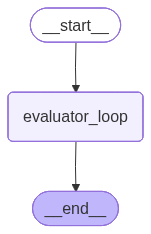

In [11]:
# ---- Invoke main graph ----
input_state = {
    "resume": resume_text,
    "job_description": job_description,
    "analyst_profiles": analysts,
    "results": []
}

output_state = main_graph.invoke(input_state)

# ---- Display results ----
print("\n=== FINAL MATCH REPORT (Map/Reduce over personas) ===\n")
for r in output_state["results"]:
    print(r)
    print("\n" + "-"*40 + "\n")

# ---- Visualize the main graph (like you had) ----
try:
    display(Image(main_graph.get_graph(xray=True).draw_mermaid_png()))
except Exception as e:
    print("Graph visualization failed:", e)

In [ ]:
# resume_jd_langgraph_pipeline.py
import json
import re
import os
from typing import TypedDict, List, Dict

from sentence_transformers import SentenceTransformer, util
from langchain_groq import ChatGroq
from langchain_core.messages import HumanMessage
from langgraph.graph import StateGraph, START, END

# =====================================================
# 1️⃣ API KEY: Set from environment variable
# =====================================================
# Option A: Hardcode (not recommended)
os.environ["GROQ_API_KEY"] = "YOUR_KEY_HERE"



# =====================================================
# 2️⃣ Embedding Model
# =====================================================
embedder = SentenceTransformer("all-MiniLM-L6-v2")

def score_similarity(resume: str, job: str) -> float:
    vec1 = embedder.encode(resume, convert_to_tensor=True)
    vec2 = embedder.encode(job, convert_to_tensor=True)
    return float(util.pytorch_cos_sim(vec1, vec2)[0][0])

# =====================================================
# 3️⃣ LLM (Groq)
# =====================================================
llm = ChatGroq(model="llama-3.1-8b-instant")

# =====================================================
# 4️⃣ Personas
# =====================================================
analysts = [
    {"name": "ATS Screener", "focus": "keywords, formatting, ATS matching"},
    {"name": "Hiring Manager", "focus": "role fit, practical skills, real projects"},
    {"name": "HR Analyst", "focus": "communication, clarity, achievements"},
]

# =====================================================
# 5️⃣ LLM JSON Evaluation Function
# =====================================================
def llm_evaluate_json(resume: str, job: str, sim_score: float, persona: Dict) -> Dict:
    prompt = f"""
You are acting as: {persona['name']} (focus: {persona['focus']}).
Compare the Resume and Job Description and return ONLY a JSON object:

{{
  "score": 0-100,
  "strengths": [],
  "missing_skills": [],
  "tips": [],
  "notes": ""
}}

Resume:
{resume}

Job Description:
{job}

Similarity Score: {sim_score:.3f}

Return ONLY JSON. NO extra text.
"""

    resp = llm.invoke([HumanMessage(content=prompt)])
    text = resp.content.strip()

    # Parse JSON
    try:
        return json.loads(text)
    except:
        # Try extracting JSON substring
        m = re.search(r"(\{[\s\S]*\})", text)
        if m:
            try:
                return json.loads(m.group(1))
            except:
                pass

    # Robust fallback
    score_match = re.search(r"(\d{1,3})", text)
    fallback_score = int(score_match.group(1)) if score_match else int(sim_score * 100)

    return {
        "score": fallback_score,
        "strengths": [],
        "missing_skills": [],
        "tips": [],
        "notes": text
    }

# =====================================================
# 6️⃣ State Definitions
# =====================================================
class MultiState(TypedDict, total=False):
    resume: str
    job_description: str
    analyst_profiles: list
    similarity: float
    evaluations: list
    final_score: float
    final_summary: dict
    report: str  # FIX: added report so LangGraph carries it

# =====================================================
# 7️⃣ Nodes
# =====================================================

def similarity_node(state: MultiState):
    sim = score_similarity(state["resume"], state["job_description"])
    return {"similarity": sim}

def evaluator_node(state: MultiState):
    sim = state.get("similarity", 0)
    evaluations = []

    for persona in state["analyst_profiles"]:
        result = llm_evaluate_json(state["resume"], state["job_description"], sim, persona)

        eval_obj = {
            "persona": persona,
            "score": int(result.get("score", int(sim * 100))),
            "strengths": result.get("strengths", []),
            "missing_skills": result.get("missing_skills", []),
            "tips": result.get("tips", []),
            "notes": result.get("notes", "")
        }
        evaluations.append(eval_obj)

    return {"evaluations": evaluations}

def aggregator_node(state: MultiState):
    evaluations = state.get("evaluations", [])

    if not evaluations:
        return {"final_score": 0, "final_summary": {}}

    avg_score = sum(e["score"] for e in evaluations) / len(evaluations)

    def unique_flat(lists):
        seen, out = set(), []
        for group in lists:
            for item in group:
                if item and item not in seen:
                    seen.add(item)
                    out.append(item)
        return out

    summary = {
        "strengths": unique_flat([e["strengths"] for e in evaluations]),
        "missing_skills": unique_flat([e["missing_skills"] for e in evaluations]),
        "top_tips": unique_flat([e["tips"] for e in evaluations]),
        "by_persona": evaluations
    }

    return {"final_score": avg_score, "final_summary": summary}

def output_node(state: MultiState):
    summary = state.get("final_summary", {})
    final_score = state.get("final_score", 0)

    report = []
    report.append("=== FINAL MATCH REPORT ===")
    report.append(f"Final Score: {final_score:.1f}/100\n")

    report.append("Top Strengths:")
    for s in summary.get("strengths", []):
        report.append(f"- {s}")

    report.append("\nMissing Skills:")
    for s in summary.get("missing_skills", []):
        report.append(f"- {s}")

    report.append("\nImprovement Tips:")
    for t in summary.get("top_tips", []):
        report.append(f"- {t}")

    report.append("\nPersona-wise Breakdown:")
    report.append(json.dumps(summary.get("by_persona", []), indent=2))

    return {"report": "\n".join(report)}

# =====================================================
# 8️⃣ Build Graph
# =====================================================
builder = StateGraph(MultiState)

builder.add_node("similarity_node", similarity_node)
builder.add_node("evaluator_node", evaluator_node)
builder.add_node("aggregator_node", aggregator_node)
builder.add_node("output_node", output_node)

builder.add_edge(START, "similarity_node")
builder.add_edge("similarity_node", "evaluator_node")
builder.add_edge("evaluator_node", "aggregator_node")
builder.add_edge("aggregator_node", "output_node")
builder.add_edge("output_node", END)

final_graph = builder.compile()

# =====================================================
# 9️⃣ Run Example
# =====================================================
if __name__ == "__main__":
    resume_text = """
    Skilled Data Analyst with strong SQL, Python, Tableau, and Excel foundation.
    Built ETL pipelines, dashboards, and implemented window functions.
    Intern at Chennai Metro — built real-time analytics for transport data.
    """

    job_description = """
    Looking for a Data Analyst with SQL, Python, data visualization skills
    (Tableau / PowerBI), problem solving ability, and business analytics mindset.
    Cloud or ML experience is a plus.
    """

    initial_state = {
        "resume": resume_text,
        "job_description": job_description,
        "analyst_profiles": analysts,
    }

    output = final_graph.invoke(initial_state)
    print("\n" + output["report"])



=== FINAL MATCH REPORT ===
Final Score: 74.0/100

Top Strengths:
- SQL
- Python
- Tableau
- data visualization skills (Tableau)
- problem solving ability
- business analytics mindset
- data visualization skills

Missing Skills:
- PowerBI
- problem solving ability
- business analytics mindset
- Cloud
- ML
- Cloud experience
- ML experience
- data visualization tool (PowerBI)

Improvement Tips:
- Highlight experience with PowerBI and problem solving ability
- Emphasize business analytics mindset
- Highlight PowerBI skills or experience
- Emphasize any cloud or ML projects
- Highlight Tableau experience
- Consider adding Cloud or ML experience

Persona-wise Breakdown:
[
  {
    "persona": {
      "name": "ATS Screener",
      "focus": "keywords, formatting, ATS matching"
    },
    "score": 70,
    "strengths": [
      "SQL",
      "Python",
      "Tableau"
    ],
    "missing_skills": [
      "PowerBI",
      "problem solving ability",
      "business analytics mindset",
      "Cloud",
